In [83]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [84]:
data_A = np.loadtxt('TSPA.csv', delimiter=';').astype(np.int64)
data_B = np.loadtxt('TSPB.csv', delimiter=';').astype(np.int64)

In [85]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int32)

In [86]:
cost_matrix_A = create_cost_matrix(data_A)

In [87]:
cost_matrix_A

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]], dtype=int32)

In [88]:
cost_matrix_B = create_cost_matrix(data_B)

In [89]:
cost_matrix_B

array([[ 928, 2934, 1498, ..., 1282, 1015, 2598],
       [1998, 1864, 1461, ..., 1008, 1949, 3567],
       [2166, 3065,  260, ..., 1582, 1685, 3135],
       ...,
       [1613, 2275, 1245, ...,  597, 1538, 3156],
       [1373, 3243, 1375, ..., 1565,  570, 2189],
       [1750, 3655, 1619, ..., 1977,  983, 1776]], dtype=int32)

## TSP with regret

In [90]:
## Simple cycle greed
def calculate_k_regret_test(mat, bool_mask, k, solution, weighted=False):
    anti_solution = sorted(list(set(range(200)) - set(solution)))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(new_mat, axis=1)
    
    regrets = sorted_mat[:, :1]
    
    biggest_regret = regrets.min()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = bool_mask.index[anti_solution][id_biggest]
    node_to_append = bool_mask.index[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret

In [91]:
def calculate_k_regret_newest(mat, bool_mask, k, solution, weighted=False):
    anti_solution = sorted(list(set(range(200)) - set(solution)))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(new_mat, axis=1)

    if weighted:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1) * (1 / sorted_mat[:, :1])
    else:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1)
    
    # print(regrets.shape, sorted_mat.shape)

    biggest_regret = regrets.max()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = bool_mask.index[anti_solution][id_biggest]
    node_to_append = bool_mask.index[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret

In [92]:
def tsp_regret(cost_matrix, starting_node, max_nodes, k=2, weighted=False):
    solution_set = set([starting_node])
    solution = [starting_node]

    ## regular greedy
    for i in range(k-1):
        previous_node = solution[-1]
        bool_mask = pd.Series(range(len(cost_matrix))).isin(solution_set)
        matrix_id = np.where(cost_matrix[previous_node][~bool_mask] == cost_matrix[previous_node][~bool_mask].min())[0][0]
        new_node = bool_mask.index[~bool_mask][matrix_id]
        solution_set.add(new_node)
        solution.append(new_node)
    total_time = 0
    
    ## tsp with regret
    while len(solution_set) < max_nodes:
        bool_mask_solution_nodes = pd.Series(range(len(cost_matrix))).isin(solution_set)
        new_node_id, node_to_append, regret_value = calculate_k_regret_newest(cost_matrix, bool_mask_solution_nodes, k, solution, weighted)
        solution.insert(solution.index(node_to_append)+1, new_node_id)
        solution_set.add(new_node_id)
        
    solution.append(solution[0])

    return solution

In [93]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [94]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]] 
    return total_sum

In [95]:
def test_solution(algorithm, cost_matrix, k, weighted=False):
    costs = []
    for i in range(len(cost_matrix)):
        cycle = algorithm(cost_matrix, i, 100, k, weighted)
        total_cost = calculate_performance(cycle, cost_matrix)
        costs.append(total_cost)
    costs = np.array(costs)
    return costs.min(), costs.max(), costs.mean()

## Dataset A

In [96]:
cycle = tsp_regret(cost_matrix_A, 0, 100, k=2)

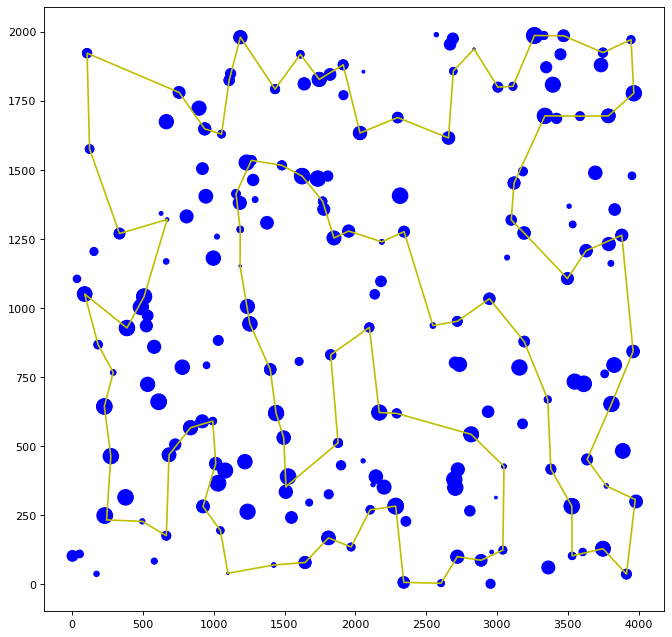

In [97]:
plot(data_A, cycle)

In [98]:
cycle = tsp_regret(cost_matrix_A, 0, 100, k=2, weighted=True)

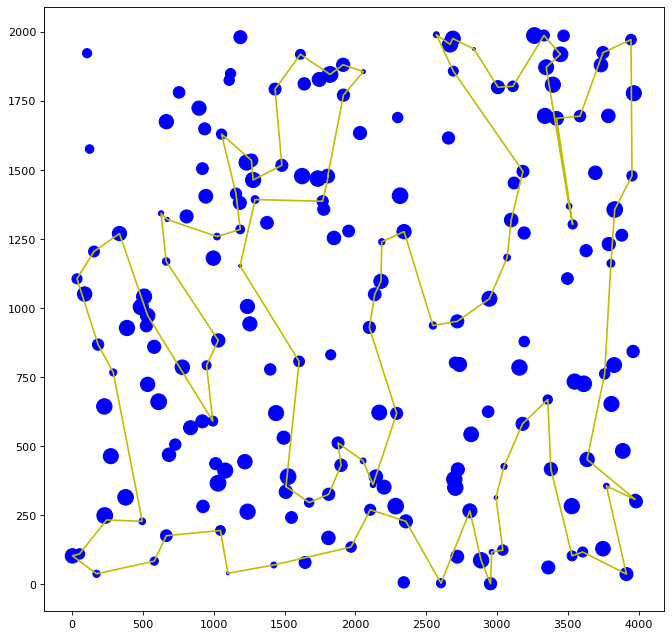

In [99]:
plot(data_A, cycle)

In [100]:
%%timeit
test_solution(tsp_regret, cost_matrix_A, k=2)

9.6 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
test_solution(tsp_regret, cost_matrix_A, k=2)

(104829, 124764, 116240.25)

In [102]:
test_solution(tsp_regret, cost_matrix_A, k=2, weighted=True)

(75052, 78929, 76698.215)

In [103]:
test_solution(tsp_regret, cost_matrix_A, k=3)

(107721, 121568, 115005.76)

In [104]:
test_solution(tsp_regret, cost_matrix_A, k=4)

(106090, 123272, 114436.815)

## Dataset B

In [105]:
cycle = tsp_regret(cost_matrix_B, 0, 100, k=2)

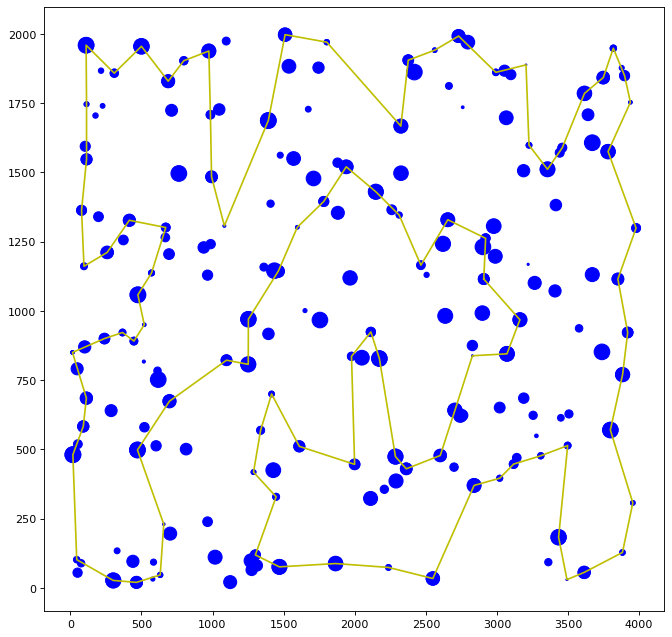

In [106]:
plot(data_B, cycle)

In [107]:
calculate_performance(cycle, cost_matrix_B)

116379

In [108]:
cycle = tsp_regret(cost_matrix_B, 0, 100, k=2, weighted=True)

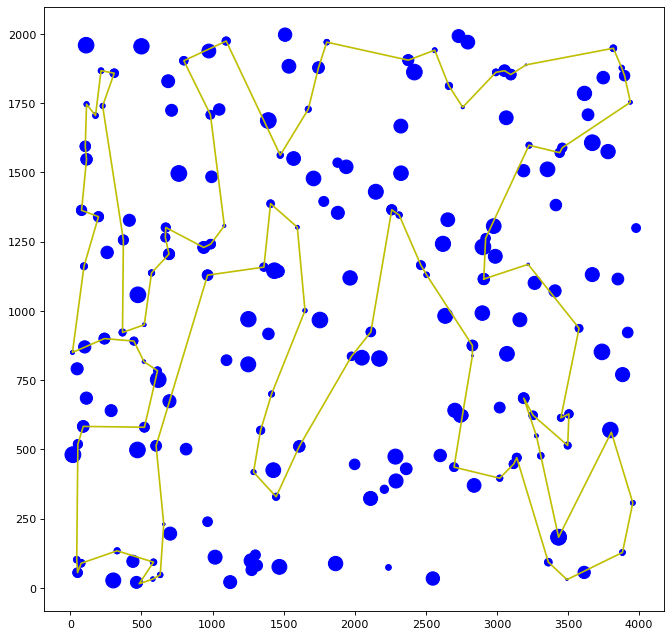

In [109]:
plot(data_B, cycle)

In [110]:
calculate_performance(cycle, cost_matrix_B)

70264

In [111]:
test_solution(tsp_regret, cost_matrix_B, k=2)

(109774, 128550, 118806.91)

In [112]:
test_solution(tsp_regret, cost_matrix_B, k=2, weighted=True)

(68743, 76640, 70150.105)

In [113]:
test_solution(tsp_regret, cost_matrix_B, k=3)

(108842, 123740, 116158.555)

In [114]:
test_solution(tsp_regret, cost_matrix_B, k=4)

(103762, 124621, 114999.72)